### Codec Comparison

In [2]:
import sys
import numpy as np
import numpy.matlib
import numpy.random
import matplotlib.pyplot as plt
import os
import cv2
import time

import scipy.io
import skimage
import imageio
import colour as c
import math
import csv
import pandas as pd
import heapq

from ipywidgets import interact, interactive, fixed, interact_manual
from mpl_toolkits.mplot3d import axes3d 
from scipy import ndimage
from scipy import misc
from scipy import fftpack
from scipy import optimize
from fnmatch import fnmatch
from datetime import datetime

In [3]:
def lin2srgb (x):
    result = (x <= 0.0031308) * np.multiply(x,12.92) + (x > 0.0031308) * np.subtract(np.multiply(1.055,np.power(x,(1/2.4))),0.055)
    return result

def srgb2lin (x):
    result = (x <= 0.04045) * np.divide(x,12.92) + (x > 0.04045) * np.power(np.divide(np.add(x,0.055),1.055),2.4)
    return result

def oetf709(x): 
    return np.subtract(np.multiply(np.power(x, 0.45), 1.099), 0.099)*(0.018<= x) + np.multiply(4.5, x) * (x <0.018)

def eotf1886(x, Lw = 100, Lb = 0): 
    gamma = 2.4
    a = np.power(np.subtract(np.power(Lw, np.divide(1,gamma)),np.power(Lb, np.divide(1, gamma))), gamma)
    b = np.divide(np.power(Lb, np.divide(1,gamma)) , np.subtract(np.power(Lw , np.divide(1,gamma)), np.power( Lb , np.divide(1, gamma))))
    return np.multiply(a , np.power( np.maximum(np.add(x, b), 0) , gamma))

def eotf1886_CRT(x, Lw = 100, Lb = 0, b = 0): 
    Vc = 0.35
    a1 = 2.6
    a2 = 3.0
    k = np.subtract(Lw,np.power(np.add(1,b),a1))
    return (x < Vc) * np.multiply(np.multiply(k,np.power(np.add(Vc,b),np.subtract(a1,a2))),np.power(np.add(x,b),a2)) + (Vc <= x) * np.multiply(k,np.power(np.add(x,b),a1))

def luma709(img): 
    return np.multiply(img[:,:,0],0.2126) + np.multiply(img[:,:,1],0.7152) + np.multiply(img[:,:,2],0.0722)

def luma2020(img): 
    return np.multiply(img[:,:,0],0.2627) + np.multiply(img[:,:,1],0.6780) + np.multiply(img[:,:,2],0.0593)

def steroids709(x): 
    return np.subtract(np.multiply(np.power(np.multiply(59.5208 , x), 0.45), 1.099), 0.099)*(0.0003024< x) + np.multiply(267.84, x) * (x <= 0.0003024)

def steroids1886(x): 
    return np.multiply(100, np.power(x, 2.4))

def pq_eotf(x): 
    ##m1
    m1 = np.divide(2610, 16384) ## 2^14 = 16384
    m2 = np.multiply(np.divide(2523, 4096), 128) ##2^12 = 4096 , 2^7 = 128 -> Jan fragen
    c1 = np.divide(3424, 4096)
    c2 = np.multiply(np.divide(2413, 4096), 32)
    c3 = np.multiply(np.divide(2392, 4096), 32)

    
    return np.multiply(np.power(np.divide(np.maximum( np.subtract( np.power(x , np.divide(1 , m2)), c1) , 0) , np.subtract(c2, np.multiply(c3 , np.power(x , np.divide(1 , m2))))) , np.divide(1, m1)), 10000)

def pq_eotf_inv(x): 
    m1 = np.divide(2610, 16384) ## 2^14 = 16384
    m2 = np.multiply(np.divide(2523, 4096), 128) ##2^12 = 4096 , 2^7 = 128 -> Jan fragen
    c1 = np.divide(3424, 4096)
    c2 = np.multiply(np.divide(2413, 4096), 32)
    c3 = np.multiply(np.divide(2392, 4096), 32)

    y = np.divide(x , 10000) ## Normalisierung auf 0.00 bis 1.0

    return np.power( np.divide(np.add(c1 , np.multiply(c2 , np.power(y , m1))), np.add(1 , np.multiply(c3 , np.power(y , m1)))), m2)

def hlg_oetf(x): 
    a = 0.17883277
    b = np.subtract(1 , np.multiply(4 , a))
    c = np.subtract(0.5 , np.multiply(a , np.log(np.multiply(4 , a))))

    return np.where(x <= np.divide(1,12), np.sqrt(np.multiply(3,x )), np.add( np.multiply(a , np.log(np.subtract( np.multiply(12 , x ), b))) , c) )

def hlg_oetf_inv(x):
    a = 0.17883277
    b = np.subtract(1 , np.multiply(4 , a))
    c = np.subtract(0.5 , np.multiply(a , np.log(np.multiply(4 , a))))
    
    return np.where(x <= 0.5 , np.divide( np.power(x,2), 3), np.divide(np.add(np.exp(np.divide(np.subtract(x , c), a)), b) , 12) )

def hlg_ootf(x, Lw): 
    r = x[: , : , 0]
    g = x[: , : , 1]
    b = x[: , : , 2]
    luma = np.add(np.multiply(0.2627 ,r ), np.multiply(0.678 , g), np.multiply(0.0593 , b))
    alpha = Lw
    gamma = np.add(1.2, np.multiply(0.42 , np.log10(np.divide(Lw,1000))))
    rd = np.multiply( alpha , np.power(luma , np.subtract(gamma , 1)), r)
    gd = np.multiply( alpha , np.power(luma , np.subtract(gamma , 1)), g)
    bd = np.multiply( alpha , np.power(luma , np.subtract(gamma , 1)), b)
    return np.stack((rd , gd , bd))

def hlg_ootf_bw(x, Lw=1000): 
    alpha = Lw
    gamma = np.add(1.2, np.multiply(0.42 , np.log10(np.divide(Lw,1000))))
    return np.multiply(np.multiply( alpha , np.power(x , np.subtract(gamma , 1))),x)

def hlg_eotf(x, Lw = 1000, Lb = 0.005):
    gamma = np.add(1.2, np.multiply(0.42 , np.log10(np.divide(Lw,1000))))
    beta = np.sqrt(np.multiply(3 , np.power(np.divide(Lb , Lw), np.divide(1,gamma))))
    return hlg_ootf_bw(hlg_oetf_inv(np.maximum(0 , (np.add( np.multiply( np.subtract(1 , beta), x ), beta)))), Lw)


def slog3oetf(x): 
    # reflection add
    x = x*0.9
    return (x < 0.01125)* np.divide( np.add( np.multiply(x , np.divide(np.subtract(171.2102946929, 95), 0.01125)), 95), 1023) + (x >= 0.01125)* np.divide(np.add(420 , np.multiply( np.log10(np.divide(np.add(x,0.01), np.add(0.18, 0.01))), 261.5)), 1023)

def slog3eotf(x): 
    return (x >= np.divide(171.2102946929,1023)) * np.subtract( np.multiply(np.power(10 , np.divide( np.subtract(420 , np.multiply(x , 1023)) , 261.5)) , np.add(0.18 , 0.01)) , 0.01) + (x < np.divide(171.2102946929,1023)) * np.multiply(np.subtract(np.multiply(x , 1023), 95 ) , np.divide(0.01125 , np.subtract(171.2102946929 , 95)))

def lin2logc(x):
    return np.multiply(x > 0.010591, 0.24719 * np.log10(5.555556 * x + 0.052272) + 0.385537) + np.multiply(x <= 0.010591, 5.367655 * x + 0.092809)

def logc2lin(x):
    return np.multiply(x > 0.149659, (np.power(10.0, (x - 0.385537) / 0.247189) - 0.052272) / 5.555556) + np.multiply(x <= 0.149659, (x - 0.092809) / 5.367650)

def Encoding_LogC4(x):
    a = (np.power(2.0, 18.0) - 16.0) / 117.45
    b = (1023.0 - 95.0) / 1023.0
    c = 95.0 / 1023.0
    s = (7 * np.log(2) * np.power(2.0, 7 - 14 * c / b)) / (a * b)
    t = (np.power(2.0, 14.0 * (-c / b) + 6.0) - 64.0) / a
    return (x < t) * np.divide(np.subtract(x,t),s) + (x >= t) * np.add(np.multiply(np.divide( np.subtract(np.log2(np.add(np.multiply(a,x),64.0)),6.0),14.0),b),c)

def Decoding_LogC4(x):
    a = (np.power(2.0, 18.0) - 16.0) / 117.45
    b = (1023.0 - 95.0) / 1023.0
    c = 95.0 / 1023.0
    s = (7 * np.log(2) * np.power(2.0, 7 - 14 * c / b)) / (a * b)
    t = (np.power(2.0, 14.0 * (-c / b) + 6.0) - 64.0) / a
    return (x < 0.0) * np.add(np.multiply(x,s),t) + (x >= 0.0) * np.divide(np.subtract(np.power(2.0, np.add(np.multiply(14,np.divide(np.subtract(x,c),b)),6)),64.0),a)


def full2legal(x):
    return (219*(x)+16)*np.power(2,(10-8))

def legal2full(x):
    return (((x/np.power(2,(10-8)))-16)/219)

def lin2log2(x):
    return np.log2(x)

def log22lin(x):
    return np.power(2,x)

def Blenden_Differenz(num1, num2):
    new2 = num2 / num1
    return np.log2(new2)

def mse_calculation(imageA, imageB):
    # Expects Luma Images
	err = np.mean(np.square(np.subtract(imageA,imageB)))
	return err

In [3]:
Matrix_LMS_XYZ = [[1.91020,-1.11212,0.20191],
                  [0.37095,0.62905,0.0],
                  [0.0,0.0,1.0]]

Matrix_BT709_XYZ = [[0.4124564, 0.3575761, 0.1804375],
                    [0.2126729, 0.7151522, 0.0721750],
                    [0.0193339, 0.1191920, 0.9503041]]

Matrix_BT2020_XYZ = [[0.636958, 0.144617, 0.168881],
                    [0.262700, 0.677998, 0.059302],
                    [0.00000, 0.028073, 1.060985]]

Matrix_BT709_BT2020 = [[0.6274, 0.3293, 0.0433],
                        [0.0691, 0.9195, 0.0114],
                        [0.0164, 0.0880, 0.8956]]

Matrix_LogC4_XYZ = [[0.704858320407232064, 0.129760295170463003, 0.115837311473976537],
                        [0.254524176404027025, 0.781477732712002049, -0.036001909116029039],
                        [0.000000000000000000, 0.000000000000000000, 1.089057750759878429]]

Matrix_XYZ_BT2020 = [[1.716651, -0.355671, -0.253366],
                        [-0.666684, 1.616481, 0.015769],
                        [0.017640, -0.042771, 0.942103]]

In [33]:
def mse_calculation(imageA, imageB):
    # Expects Luma Images
	err = np.mean(np.square(np.subtract(imageA,imageB)))
	return err

from math import log10, sqrt 
import cv2 
import numpy as np
from skimage.metrics import structural_similarity as ssim_calculation

def PSNR_calculation(original, compressed): 

	# Expects Luma Images
	mse = mse_calculation(original,compressed)
	if(mse == 0): # MSE is zero means no noise is present in the signal . 
				# Therefore PSNR have no importance. 
		return 100
	max_pixel = 1023.0
	psnr = 20 * log10(max_pixel / sqrt(mse)) 
	return psnr 

def delta_E_ITP_calculation(original,compressed):

	# Recommendation ITU-R BT.2124-0
	# Expects Display-Linear RGB with 1 = 1 cd/m2
	L1 = (1688*original[:,:,0] + 2146*original[:,:,1] + 262*original[:,:,2])/4096
	M1 = (683*original[:,:,0] + 2951*original[:,:,1] + 462*original[:,:,2])/4096
	S1 = (99*original[:,:,0] + 309*original[:,:,1] + 3688*original[:,:,2])/4096

	L1_Mapped = c.models.eotf_inverse_ST2084(L1)
	M1_Mapped = c.models.eotf_inverse_ST2084(M1)
	S1_Mapped = c.models.eotf_inverse_ST2084(S1)

	I1 = 0.5*L1_Mapped+0.5*M1_Mapped
	CT1 =(6610*L1_Mapped - 13613*M1_Mapped + 7003*S1_Mapped)/4096
	CP1 =(17933*L1_Mapped - 17390*M1_Mapped - 543*S1_Mapped)/4096

	I1 = I1
	T1 = 0.5 * CT1
	P1 = CP1

	L2 = (1688*compressed[:,:,0] + 2146*compressed[:,:,1] + 262*compressed[:,:,2])/4096
	M2 = (683*compressed[:,:,0] + 2951*compressed[:,:,1] + 462*compressed[:,:,2])/4096
	S2 = (99*compressed[:,:,0] + 309*compressed[:,:,1] + 3688*compressed[:,:,2])/4096

	L2_Mapped = c.models.eotf_inverse_ST2084(L2)
	M2_Mapped = c.models.eotf_inverse_ST2084(M2)
	S2_Mapped = c.models.eotf_inverse_ST2084(S2)

	I2 = 0.5*L2_Mapped+0.5*M2_Mapped
	CT2 =(6610*L2_Mapped - 13613*M2_Mapped + 7003*S2_Mapped)/4096
	CP2 =(17933*L2_Mapped - 17390*M2_Mapped - 543*S2_Mapped)/4096

	I2 = I2
	T2 = 0.5 * CT2
	P2 = CP2

	return np.multiply(720,np.sqrt(np.add(np.power(np.subtract(I1,I2),2),np.add(np.power(np.subtract(T1,T2),2),np.power(np.subtract(P1,P2),2)))))

def delta_E_ITP_visualisation(delta_array, image, factor):
    container = np.zeros((len(delta_array[:, 0]), len(delta_array[0, :]), 3))
    mask1 = 1 >= delta_array
    mask2 = 1 <= delta_array
    mask3 = 2 < delta_array
    mask4 = 3 < delta_array
    mask5 = 4 < delta_array

    container[mask1] = [0, 0, 1]
    container[mask2] = [0, 1, 1]
    container[mask3] = [0, 1, 0]
    container[mask4] = [1, 1, 0]
    container[mask5] = [1, 0, 0]

    return image * (1 - factor) + container * factor

# SSIM expects Luma Values!!
def Auswertung_Encoding_PQ_UHD(ref,ref_encoding,comp,comp_encoding,factor,target,L_min_hlg=0,L_max_hlg=1000):

    ref_display_linear = ref
    comp_display_linear = comp

    # if ref_encoding == "pq_full":
    #     ref_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(ref,1023),4),1023)),0,100000)

    # elif ref_encoding == "pq_narrow":
    #     ref_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(legal2full(ref*1023),1023),4),1023)),0,100000)

    # elif ref_encoding == "hlg_full":
    #     ref_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(ref,1023),4),1023),L_min_hlg,1000),0,100000)

    # elif ref_encoding == "hlg_narrow":
    #     ref_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(legal2full(ref*1023),1023),4),1023),0,1000),0,100000)

    # if comp_encoding == "pq_full":
    #     comp_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(comp,1023),4),1023)),0,100000)

    # elif comp_encoding == "pq_narrow":
    #     comp_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(legal2full(comp*1023),1023),4),1023)),0,100000)

    # elif comp_encoding == "hlg_full":
    #     comp_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(comp,1023),4),1023),0,1000),0,100000)

    # elif comp_encoding == "hlg_narrow":
    #     comp_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(legal2full(comp*1023),1023),4),1023),0,1000),0,100000)

    ref_display_linear_luma2020 = luma2020(ref)
    comp_display_linear_luma2020 = luma2020(comp)

    # Calculation of MSE
    mse = np.round(mse_calculation(ref_display_linear_luma2020,comp_display_linear_luma2020),4)

    # Calculation of PSNR
    psnr = np.round(PSNR_calculation(ref_display_linear_luma2020,comp_display_linear_luma2020),4)

    # Calculation of SSIM
    ssim = np.round(ssim_calculation(ref_display_linear_luma2020,comp_display_linear_luma2020),4)

    # Calculation of Minimum delta E
    delta_e_array = delta_E_ITP_calculation(ref_display_linear,comp_display_linear)

    # Visualisation of Minimum delta E
    delta_e_image = delta_E_ITP_visualisation(delta_e_array,c.models.eotf_inverse_HLG_BT2100(ref,0.005,1000),factor)

    figR, (axR,axL) = plt.subplots(1, 2, figsize=(16, 16),gridspec_kw={'width_ratios': [len(delta_e_image[0,:,0]), len(delta_e_image[0,:,0])/32]})
    axR.imshow(delta_e_image)
    # axR.text(len(delta_e_image[:,0,0])/2-(len(delta_e_image[:,0,0])/2)+(len(delta_e_image[:,0,0])/3.5),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/12),f"MSE: {mse}",fontsize=18)
    # axR.text(len(delta_e_image[:,0,0])/2+(len(delta_e_image[:,0,0])/3.5),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/12),f"PSNR: {psnr}",fontsize=18)
    # axR.text(len(delta_e_image[:,0,0])/2+(len(delta_e_image[:,0,0])/2)+(len(delta_e_image[:,0,0])/3.5),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/12),f"SSIM: {ssim}",fontsize=18)
    #axR.text(len(delta_e_image[:,0,0])/2-(len(delta_e_image[:,0,0])/2),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/8),"Reference:   " + ref_name,fontsize=7)
    #axR.text(len(delta_e_image[:,0,0])/2-(len(delta_e_image[:,0,0])/2),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/8)+(len(delta_e_image[:,0,0])/30),"Comparison:   " + comp_name,fontsize=7)

    legend = delta_e_image
    pos1_y = int(len(delta_e_image[:,0,0])/5*0)
    pos2_y = int(len(delta_e_image[:,0,0])/5*1)
    pos3_y = int(len(delta_e_image[:,0,0])/5*2)
    pos4_y = int(len(delta_e_image[:,0,0])/5*3)
    pos5_y = int(len(delta_e_image[:,0,0])/5*4)
    pos_y_max = int(len(delta_e_image[:,0,0]))
    legend[pos1_y:pos_y_max,:,:] = [1, 0, 0]
    legend[pos2_y:pos_y_max,:,:] = [1, 1, 0]
    legend[pos3_y:pos_y_max,:,:] = [0, 1, 0]
    legend[pos4_y:pos_y_max,:,:] = [0, 1, 1]
    legend[pos5_y:pos_y_max,:,:] = [0, 0, 1]

    height = int(len(delta_e_image[0,:,0])/32)
    axL.imshow(legend[:,0:height,:])
    marker = [pos1_y,pos2_y,pos3_y,pos4_y,pos5_y,pos_y_max]
    marker_content = ["inf",4,3,2,1,0]
    axL.set_yticks(marker,marker_content)
    axL.set_ylabel("delta E ITP")
    axL.set_xticks([],[])

    figR.savefig(target)
    figR.clf()
    plt.close(figR)

    csv_file_name = target + "_delta_E_map.csv"

    with open(csv_file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in delta_e_array:
            writer.writerow(row)

def Auswertung_Encoding_PQ_HD(ref,ref_encoding,comp,comp_encoding,factor,target,L_min_hlg=0,L_max_hlg=1000):

    ref_name = ref
    comp_name = comp

    ref = c.read_image(ref)
    print(np.max(ref))
    comp = c.read_image(comp)
    print(np.max(comp))
    
    if ref_encoding == "pq_full":
        ref_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(ref,1023),4),1023)),0,100000)

    elif ref_encoding == "pq_narrow":
        ref_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(legal2full(ref*1023),1023),4),1023)),0,100000)

    elif ref_encoding == "hlg_full":
        ref_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(ref,1023),4),1023),L_min_hlg,1000),0,100000)

    elif ref_encoding == "hlg_narrow":
        ref_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(legal2full(ref*1023),1023),4),1023),0,1000),0,100000)

    if comp_encoding == "pq_full":
        comp_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(comp,1023),4),1023)),0,100000)

    elif comp_encoding == "pq_narrow":
        comp_display_linear = np.clip(c.models.eotf_ST2084(np.divide(np.round(np.multiply(legal2full(comp*1023),1023),4),1023)),0,100000)

    elif comp_encoding == "hlg_full":
        comp_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(comp,1023),4),1023),0,1000),0,100000)

    elif comp_encoding == "hlg_narrow":
        comp_display_linear = np.clip(c.models.eotf_HLG_BT2100(np.divide(np.round(np.multiply(legal2full(comp*1023),1023),4),1023),0,1000),0,100000)

    ref_display_linear_luma2020 = luma2020(ref_display_linear)
    comp_display_linear_luma2020 = luma2020(comp_display_linear)

    # Calculation of MSE
    mse = np.round(mse_calculation(ref_display_linear_luma2020,comp_display_linear_luma2020),4)

    # Calculation of PSNR
    psnr = np.round(PSNR_calculation(ref_display_linear_luma2020,comp_display_linear_luma2020),4)

    # Calculation of SSIM
    ssim = np.round(ssim_calculation(ref_display_linear_luma2020,comp_display_linear_luma2020),4)

    # Calculation of Minimum delta E
    delta_e_array = delta_E_ITP_calculation(ref,comp)

    # Visualisation of Minimum delta E
    delta_e_image = delta_E_ITP_visualisation(delta_e_array,ref,factor)

    figR, (axR,axL) = plt.subplots(1, 2, figsize=(16, 16),gridspec_kw={'width_ratios': [len(delta_e_image[0,:,0]), len(delta_e_image[0,:,0])/32]})
    axR.imshow(delta_e_image)
    # axR.text(len(delta_e_image[:,0,0])/2-(len(delta_e_image[:,0,0])/2)+(len(delta_e_image[:,0,0])/3.2),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/12),f"MSE: {mse}",fontsize=18)
    # axR.text(len(delta_e_image[:,0,0])/2+(len(delta_e_image[:,0,0])/3.2),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/12),f"PSNR: {psnr}",fontsize=18)
    # axR.text(len(delta_e_image[:,0,0])/2+(len(delta_e_image[:,0,0])/2)+(len(delta_e_image[:,0,0])/3.2),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/12),f"SSIM: {ssim}",fontsize=18)
    axR.text(len(delta_e_image[:,0,0])/2-(len(delta_e_image[:,0,0])/2),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/8),"Reference:   " + ref_name,fontsize=7)
    axR.text(len(delta_e_image[:,0,0])/2-(len(delta_e_image[:,0,0])/2),len(delta_e_image[:,0,0])+(len(delta_e_image[:,0,0])/8)+(len(delta_e_image[:,0,0])/30),"Comparison:   " + comp_name,fontsize=7)

    legend = delta_e_image
    pos1_y = int(len(delta_e_image[:,0,0])/5*0)
    pos2_y = int(len(delta_e_image[:,0,0])/5*1)
    pos3_y = int(len(delta_e_image[:,0,0])/5*2)
    pos4_y = int(len(delta_e_image[:,0,0])/5*3)
    pos5_y = int(len(delta_e_image[:,0,0])/5*4)
    pos_y_max = int(len(delta_e_image[:,0,0]))
    legend[pos1_y:pos_y_max,:,:] = [1, 0, 0]
    legend[pos2_y:pos_y_max,:,:] = [1, 1, 0]
    legend[pos3_y:pos_y_max,:,:] = [0, 1, 0]
    legend[pos4_y:pos_y_max,:,:] = [0, 1, 1]
    legend[pos5_y:pos_y_max,:,:] = [0, 0, 1]

    height = int(len(delta_e_image[0,:,0])/32)
    axL.imshow(legend[:,0:height,:])
    marker = [pos1_y,pos2_y,pos3_y,pos4_y,pos5_y,pos_y_max]
    marker_content = ["inf",4,3,2,1,0]
    axL.set_yticks(marker,marker_content)
    axL.set_ylabel("Just Noticable Difference in dE")
    axL.set_xticks([],[])

    figR.savefig(target)
    figR.clf()
    plt.close(figR)

    csv_file_name = target + "_delta_E_map.csv"

    with open(csv_file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in delta_e_array:
            writer.writerow(row)

In [21]:
new_array = np.zeros((2160,16000,3))
new_array[0,:,0] = np.logspace(-3,3,16000)
for i in range(2160):
    new_array[i,:,0] = new_array[0,:,0]
new_array[:,:,1] = new_array[:,:,0]
new_array[:,:,2] = new_array[:,:,0]

In [44]:
c.models.eotf_ST2084(legal2full(854))

3972.4025190837679

In [49]:
import numpy as np

# Sample arrays
array1 = np.array(c.models.eotf_HLG_BT2100(legal2full(np.linspace(64,940,877)),0.005,4000))
array2 = np.array(c.models.eotf_ST2084(legal2full(np.linspace(78,854,777))))

# Create a new array
new_array = []

# Iterate through each element in array1
for value in array1:
    # Find the closest value in array2
    closest_value = min(array2, key=lambda x: abs(x - value))
    
    # Append a pair [value_from_array1, closest_value_from_array2] to the new array
    new_array.append([value, closest_value])

# Convert the new array to a NumPy array
new_array_HLG = np.array(new_array)

print(new_array)



import numpy as np

# Sample arrays
array2 = np.array(c.models.eotf_HLG_BT2100(legal2full(np.linspace(64,940,877)),0.005,4000))
array1 = np.array(c.models.eotf_ST2084(legal2full(np.linspace(78,854,777))))

# Create a new array
new_array = []

# Iterate through each element in array1
for value in array1:
    # Find the closest value in array2
    closest_value = min(array2, key=lambda x: abs(x - value))
    
    # Append a pair [value_from_array1, closest_value_from_array2] to the new array
    new_array.append([value, closest_value])

# Convert the new array to a NumPy array
new_array_PQ = np.array(new_array)

print(new_array)


new_test_array_HLG = np.zeros((2160,3840,3))

new_test_array_HLG[0,0:877,0] = new_array_HLG[:,0]
new_test_array_HLG[0,0:877,1] = new_array_HLG[:,0]
new_test_array_HLG[0,0:877,2] = new_array_HLG[:,0]



new_test_array_PQ = np.zeros((2160,3840,3))

new_test_array_PQ[0,0:877,0] = new_array_HLG[:,1]
new_test_array_PQ[0,0:877,1] = new_array_HLG[:,1]
new_test_array_PQ[0,0:877,2] = new_array_HLG[:,1]


new_test_array_HLG1 = np.zeros((2160,3840,3))

new_test_array_HLG1[0,0:777,0] = new_array_PQ[:,0]
new_test_array_HLG1[0,0:777,1] = new_array_PQ[:,0]
new_test_array_HLG1[0,0:777,2] = new_array_PQ[:,0]



new_test_array_PQ1 = np.zeros((2160,3840,3))

new_test_array_PQ1[0,0:777,0] = new_array_PQ[:,1]
new_test_array_PQ1[0,0:777,1] = new_array_PQ[:,1]
new_test_array_PQ1[0,0:777,2] = new_array_PQ[:,1]



new_test_array_HLG[1:,:, :] = new_test_array_HLG[0,:,:]
new_test_array_HLG1[1:,:, :] = new_test_array_HLG1[0,:,:]
new_test_array_PQ[1:,:, :] = new_test_array_PQ[0,:,:]
new_test_array_PQ1[1:,:, :] = new_test_array_PQ1[0,:,:]


[[0.0050000000000000044, 0.0055938061006096211], [0.0060818029271306412, 0.0063938605542215032], [0.0073066999801151321, 0.0072522635156068802], [0.0086831145327738238, 0.0091490470055897478], [0.010219421440769967, 0.01018996717705101], [0.011923950102082949, 0.012463413843741885], [0.013804987167808331, 0.013698634410638604], [0.015870778959308308, 0.016372979320192559], [0.018129533636435276, 0.017814934255923419], [0.020589423152955172, 0.020915647321149398], [0.023258585028666401, 0.022577364193536009], [0.026145123962529312, 0.026131071879122128], [0.029257113307026621, 0.030002124076051656], [0.032602596420705156, 0.032060599062800739], [0.03618958791321264, 0.036431517331512009], [0.040026074794998041, 0.041152063578670524], [0.044120017542085228, 0.043647652206005215], [0.048479351084876873, 0.048918055800086568], [0.053111985728735149, 0.051696373125807486], [0.058025808013075331, 0.057548157239613706], [0.063228681514853641, 0.063805621261669443], [0.068728447601609483, 0.06

In [ ]:
import numpy as np

# Sample arrays
array1 = np.array(c.models.eotf_HLG_BT2100(legal2full(np.linspace(64,940,877)),0.005,1000))
array2 = np.array(np.clip(c.models.eotf_ST2084(legal2full(np.linspace(78,722,645))),0.005,1000))

# Create a new array
new_array = []

# Iterate through each element in array1
for value in array1:
    # Find the closest value in array2
    closest_value = min(array2, key=lambda x: abs(x - value))
    
    # Append a pair [value_from_array1, closest_value_from_array2] to the new array
    new_array.append([value, closest_value])

# Convert the new array to a NumPy array
new_array_HLG = np.array(new_array)

print(new_array)



import numpy as np

# Sample arrays
array2 = np.array(c.models.eotf_HLG_BT2100(legal2full(np.linspace(64,940,877)),0.005,1000))
array1 = np.array(c.models.eotf_ST2084(legal2full(np.linspace(78,722,645))))

# Create a new array
new_array = []

# Iterate through each element in array1
for value in array1:
    # Find the closest value in array2
    closest_value = min(array2, key=lambda x: abs(x - value))
    
    # Append a pair [value_from_array1, closest_value_from_array2] to the new array
    new_array.append([value, closest_value])

# Convert the new array to a NumPy array
new_array_PQ = np.array(new_array)

print(new_array)


new_test_array_HLG = np.zeros((2160,3840,3))

new_test_array_HLG[0,0:877,0] = new_array_HLG[:,0]
new_test_array_HLG[0,0:877,1] = new_array_HLG[:,0]
new_test_array_HLG[0,0:877,2] = new_array_HLG[:,0]



new_test_array_PQ = np.zeros((2160,3840,3))

new_test_array_PQ[0,0:877,0] = new_array_HLG[:,1]
new_test_array_PQ[0,0:877,1] = new_array_HLG[:,1]
new_test_array_PQ[0,0:877,2] = new_array_HLG[:,1]


new_test_array_HLG1 = np.zeros((2160,3840,3))

new_test_array_HLG1[0,0:645,0] = new_array_PQ[:,0]
new_test_array_HLG1[0,0:645,1] = new_array_PQ[:,0]
new_test_array_HLG1[0,0:645,2] = new_array_PQ[:,0]



new_test_array_PQ1 = np.zeros((2160,3840,3))

new_test_array_PQ1[0,0:645,0] = new_array_PQ[:,1]
new_test_array_PQ1[0,0:645,1] = new_array_PQ[:,1]
new_test_array_PQ1[0,0:645,2] = new_array_PQ[:,1]



new_test_array_HLG[1:,:, :] = new_test_array_HLG[0,:,:]
new_test_array_HLG1[1:,:, :] = new_test_array_HLG1[0,:,:]
new_test_array_PQ[1:,:, :] = new_test_array_PQ[0,:,:]
new_test_array_PQ1[1:,:, :] = new_test_array_PQ1[0,:,:]


In [40]:
test01_ref = c.models.eotf_HLG_BT2100(c.read_image("/Volumes/T7_Shield/10_SOURCE_CORRECT_UHD_selection/12.1_TRANSFORMED_HLG_FR_UHD/20231219_HdM_HDR_2023_VideoDisco_V2_Selection/TRANSFORMED_HLG_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_193390/TRANSFORMED_HLG_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_193390.tif"),0,1000)
test_vgl = c.models.eotf_HLG_BT2100(c.read_image("/Volumes/T7_Shield/41.1_TIFF_EXTRACTION_NEW/HLG_UHD/08_XAVC-I/20231219_HdM_HDR_2023_VideoDisco_V2_Selection/TRANSFORMED_HLG_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_193390/Dublicated_TIFF_TRANSFORMED_HLG_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_193390.tif_000000.000000.tif"),0,1000)

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [51]:
Auswertung_Encoding_PQ_UHD(new_test_array_HLG,"hlg_full",new_test_array_PQ,"pq_full",0.5,"/Users/justus/Desktop/4k_test_HLG_HLG.tiff",L_min_hlg=0.005,L_max_hlg=1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [53]:
c.write_image(new_test_array_PQ1,"/Users/justus/Desktop/PQ_Verlauf_4000_in_PQ.tiff")

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [17]:
Auswertung_Encoding_PQ_HD("/Volumes/T7_Shield/11.1_Source_Content_Scaled_10bit_Narrow_Range/PQ_HD/13.1_TRANSFORMED_PQ_FR_HD/HdM-HDR-2014_Color-Graded-for-HDR_Selection/TRANSFORMED_PQ_BT2020_FR_HD_carousel_fireworks_095443/10bit_Narrow_Range_TRANSFORMED_PQ_BT2020_FR_HD_carousel_fireworks_095443_00000000.tif","pq_narrow","/Volumes/T7_Shield/11.1_Source_Content_Scaled_10bit_Narrow_Range/HLG_HD/14.1_TRANSFORMED_HLG_FR_HD/HdM-HDR-2014_Color-Graded-for-HDR_Selection/TRANSFORMED_HLG_BT2020_FR_HD_carousel_fireworks_095443/10bit_Narrow_Range_TRANSFORMED_HLG_BT2020_FR_HD_carousel_fireworks_095443_00000000.tif","hlg_narrow",0.75,"/Users/justus/Desktop/Delta_E_Ergebnisse",L_min_hlg=0.005,L_max_hlg=1000)

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [ ]:
# PQ UHD FULL
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/01.1_ARRI_Encounters_PQ_UHD_FR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/01.1_ARRI_Encounters_PQ_UHD_FR"


for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/61_AUSWERTUNG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_UHD(ref_path,"pq_full",comp_path,"pq_full",0.85,new_name)
                    print(new_name)

In [ ]:
import os

def rename_files(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            # Get the name of the current folder
            folder_name = os.path.basename(root)
            
            # Create the new file name by combining folder name and ".tif" suffix
            new_file_name = f"{folder_name}_00000000.tif"
            
            # Create the full paths for the old and new file names
            old_file_path = os.path.join(root, file_name)
            new_file_path = os.path.join(root, new_file_name)
            
            # Rename the file
            os.rename(old_file_path, new_file_path)
            print(f"Renamed: {old_file_path} -> {new_file_path}")

# Specify the root folder path
root_folder = "/Volumes/T7_Shield/11.1_Source_Content_Scaled/PQ_UHD/13.1_TRANSFORMED_PQ_FR_P3Lim_HD"

# Call the function to rename files
rename_files(root_folder)


# Working

In [ ]:
import os
import shutil

def delete_folders_with_keyword(root_directory, keyword):
    for foldername, subfolders, filenames in os.walk(root_directory, topdown=False):
        # Check if the keyword is present in the folder name
        if keyword in foldername:
            try:
                # Remove the folder and its contents
                shutil.rmtree(foldername)
                print(f'Deleted: {foldername}')
            except Exception as e:
                print(f'Error deleting {foldername}: {e}')

# Replace 'your_directory_path' with the root directory where you want to start the deletion process
directory_path = '/Volumes/jm_HDD/41_TIFF_EXTRACTION/'
keyword_to_delete = 'P3Lim'

delete_folders_with_keyword(directory_path, keyword_to_delete)


*T2020_FR_UHD_A001C015_220324_R089*
Habs fundelt
/Volumes/T7_Shield/11.1_Source_Content_Scaled/HLG_HD/12.1_TRANSFORMED_HLG_FR_UHD/ARRI_Encounters/10_A001C015_220324_R089/TRANSFORMED_HLG_BT2020_FR_UHD_A001C015_220324_R089.00000000.tif
/Volumes/T7_Shield/41_TIFF_EXTRACTION/33.1_PQ_HD/05_HEVC/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/10_A001C015_220324_R089/TRANSFORMED_PQ_BT2020_FR_UHD_A001C015_220324_R089.00000000.tif/Dublicated_TIFF_TRANSFORMED_PQ_BT2020_FR_UHD_A001C015_220324_R089.00000000.tif_000000_V1-0071.000000.tif
/Volumes/T7_Shield/65_AUSWERTUNG/33.1_PQ_HD/05_HEVC/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/10_A001C015_220324_R089/TRANSFORMED_PQ_BT2020_FR_UHD_A001C015_220324_R089.00000000.tif/Dublicated_TIFF_TRANSFORMED_PQ_BT2020_FR_UHD_A001C015_220324_R089.00000000.tif_000000_V1-0071.000000.tif_Analysis_MSE_PSNR_SSIM_JND.tif
Habs fundelt
/Volumes/T7_Shield/11.1_Source_Content_Scaled/HLG_HD/12.1_TRANSFORMED_HLG_FR_UHD/ARRI_Encounters/10_A001C015_220324_R089/TRANSFORMED_HLG_BT2020

KeyboardInterrupt: 

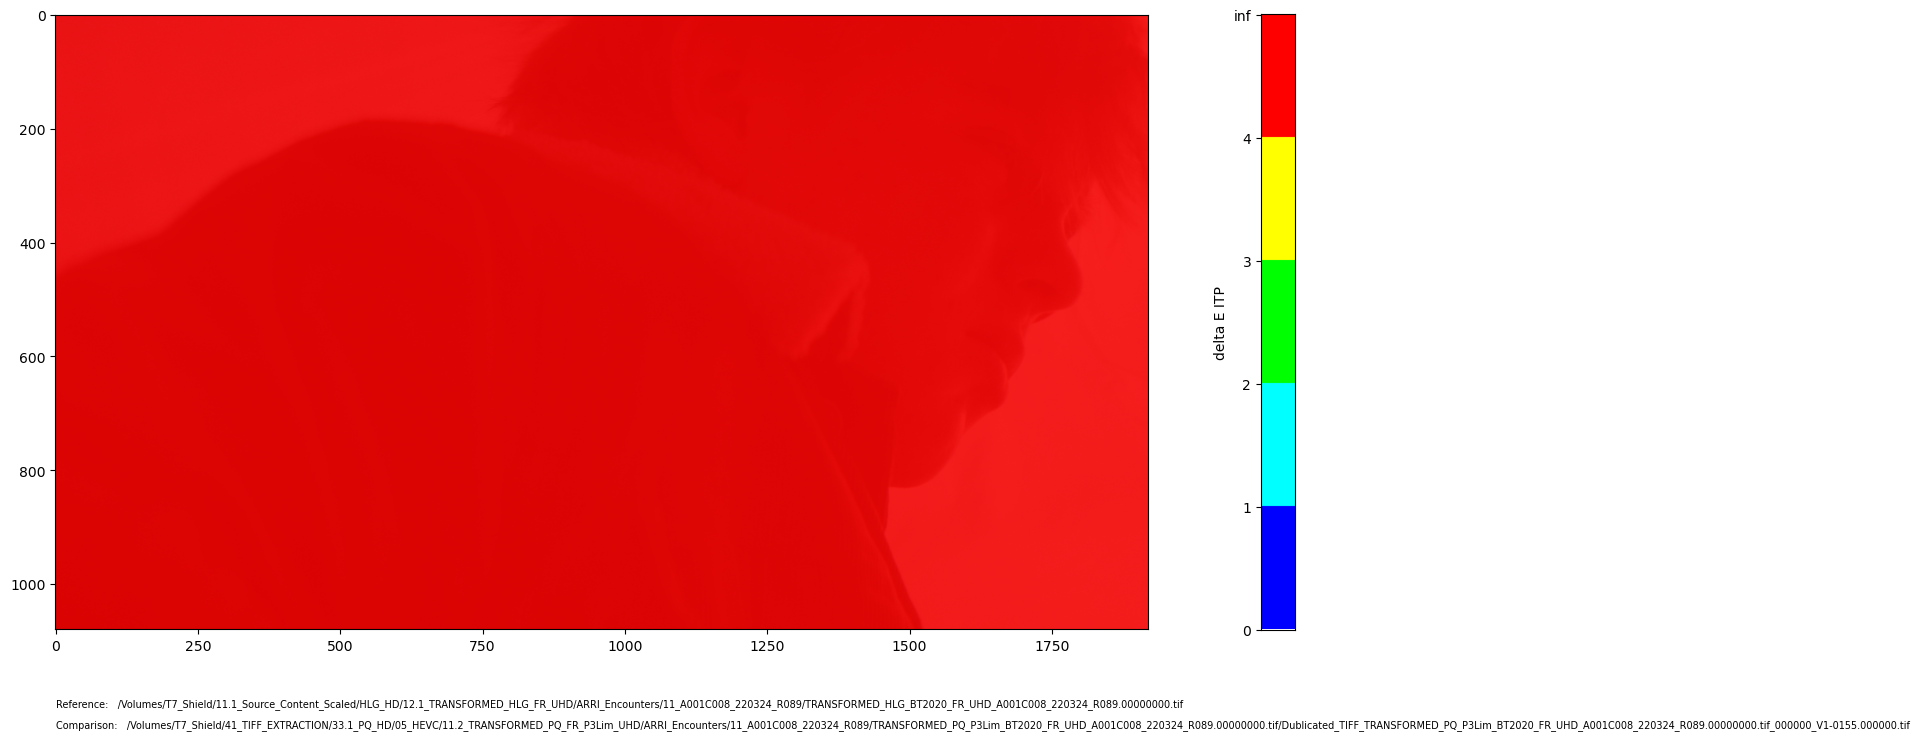

In [9]:
# PQ UHD FULL NEUUU
root = '/Volumes/T7_Shield/41_TIFF_EXTRACTION/33.1_PQ_HD'
ref_root = "/Volumes/T7_Shield/11.1_Source_Content_Scaled/HLG_HD"


pattern1 = "TR*"
pattern2 = "Du*"


for path, subdirs, files in os.walk(ref_root):
    for name in files:
        if fnmatch(name, pattern1):
                name_pattern = f"*{name[17:-13]}*"
                print(name_pattern)
                ref_path = os.path.join(path,name)

                for path, subdirs, files in os.walk(root):
                    for name1 in files:
                        if fnmatch(name1, name_pattern):
                            print("Habs fundelt")
                            print(ref_path)
                            print(os.path.join(path,name1))
                            comp_path = os.path.join(path,name1)
                            store_path = comp_path
                            store_path = store_path.replace("/Volumes/T7_Shield/41_TIFF_EXTRACTION/","/Volumes/T7_Shield/65_AUSWERTUNG/")
                            if not os.path.exists(store_path):
                                os.makedirs(store_path)
                            new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                            Auswertung_Encoding_PQ_HD(ref_path,"hlg_full",comp_path,"pq_full",0.85,new_name)
                            print(new_name)

In [ ]:
# PQ UHD FULL NEUUU
root = '/Volumes/jm_HDD/41_TIFF_EXTRACTION/32.1_HLG_UHD'
ref_root = "/Volumes/T7_Shield/11.1_Source_Content_Scaled/HLG_UHD"


pattern1 = "TR*"
pattern2 = "Du*"


for path, subdirs, files in os.walk(ref_root):
    for name in files:
        if fnmatch(name, pattern1):
                name_pattern = f"*{name[17:-13]}*"
                print(name_pattern)
                ref_path = os.path.join(path,name)

                for path, subdirs, files in os.walk(root):
                    for name1 in files:
                        if fnmatch(name1, name_pattern):
                            print("Habs fundelt")
                            print(ref_path)
                            print(os.path.join(path,name1))
                            comp_path = os.path.join(path,name1)
                            store_path = comp_path
                            store_path = store_path.replace("/Volumes/jm_HDD/41_TIFF_EXTRACTION/","/Volumes/T7_Shield/65_AUSWERTUNG/")
                            if not os.path.exists(store_path):
                                os.makedirs(store_path)
                            new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                            Auswertung_Encoding_PQ_UHD(ref_path,"hlg_full",comp_path,"hlg_full",0.85,new_name)
                            print(new_name)

In [ ]:
# PQ UHD FULL NEUUU
root = '/Volumes/jm_HDD/41_TIFF_EXTRACTION/34.1_HLG_HD'
ref_root = "/Volumes/T7_Shield/11.1_Source_Content_Scaled/HLG_HD"

pattern1 = "TR*"
pattern2 = "Du*"


for path, subdirs, files in os.walk(ref_root):
    for name in files:
        if fnmatch(name, pattern1):
                name_pattern = f"*{name[17:-13]}*"
                print(name_pattern)
                ref_path = os.path.join(path,name)

                for path, subdirs, files in os.walk(root):
                    for name1 in files:
                        if fnmatch(name1, name_pattern):
                            print("Habs fundelt")
                            print(ref_path)
                            print(os.path.join(path,name1))
                            comp_path = os.path.join(path,name1)
                            store_path = comp_path
                            store_path = store_path.replace("/Volumes/jm_HDD/41_TIFF_EXTRACTION/","/Volumes/T7_Shield/65_AUSWERTUNG/")
                            if not os.path.exists(store_path):
                                os.makedirs(store_path)
                            new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                            Auswertung_Encoding_PQ_HD(ref_path,"hlg_full",comp_path,"hlg_full",0.85,new_name)
                            print(new_name)

In [ ]:
# PQ UHD FULL NEUUU
root = '/Volumes/jm_HDD/41_TIFF_EXTRACTION/33.1_PQ_HD'
ref_root = "/Volumes/T7_Shield/11.1_Source_Content_Scaled/HLG_HD"


pattern1 = "TR*"
pattern2 = "Du*"


for path, subdirs, files in os.walk(ref_root):
    for name in files:
        if fnmatch(name, pattern1):
                name_pattern = f"*{name[17:-13]}*"
                print(name_pattern)
                ref_path = os.path.join(path,name)

                for path, subdirs, files in os.walk(root):
                    for name1 in files:
                        if fnmatch(name1, name_pattern):
                            print("Habs fundelt")
                            print(ref_path)
                            print(os.path.join(path,name1))
                            comp_path = os.path.join(path,name1)
                            store_path = comp_path
                            store_path = store_path.replace("/Volumes/jm_HDD/41_TIFF_EXTRACTION/","/Volumes/T7_Shield/65_AUSWERTUNG/")
                            if not os.path.exists(store_path):
                                os.makedirs(store_path)
                            new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                            Auswertung_Encoding_PQ_HD(ref_path,"hlg_full",comp_path,"pq_full",0.85,new_name)
                            print(new_name)

In [ ]:
# PQ UHD FULL NEUUU
root = '/Volumes/jm_HDD/41_TIFF_EXTRACTION/33.1_PQ_HD'
ref_root = "/Volumes/T7_Shield/11.1_Source_Content_Scaled/PQ_HD"


pattern1 = "TR*"
pattern2 = "Du*"


for path, subdirs, files in os.walk(ref_root):
    for name in files:
        if fnmatch(name, pattern1):
                name_pattern = f"*{name[:-13]}*"
                print(name[:-13])
                ref_path = os.path.join(path,name)

                for path, subdirs, files in os.walk(root):
                    for name1 in files:
                        if fnmatch(name1, name_pattern):
                            print("Habs fundelt")
                            print(ref_path)
                            print(os.path.join(path,name1))
                            comp_path = os.path.join(path,name1)
                            store_path = comp_path
                            store_path = store_path.replace("/Volumes/jm_HDD/41_TIFF_EXTRACTION/","/Volumes/T7_Shield/61_AUSWERTUNG/")
                            if not os.path.exists(store_path):
                                os.makedirs(store_path)
                            new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                            Auswertung_Encoding_PQ_HD(ref_path,"pq_full",comp_path,"pq_full",0.85,new_name)
                            print(new_name)

In [ ]:
# PQ UHD FULL NEUUU
root = '/Volumes/jm_HDD/41_TIFF_EXTRACTION/34.1_HLG_HD'
ref_root = "/Volumes/T7_Shield/11.1_Source_Content_Scaled/HLG_HD"


pattern1 = "TR*"
pattern2 = "Du*"


for path, subdirs, files in os.walk(ref_root):
    for name in files:
        if fnmatch(name, pattern1):
                name_pattern = f"*{name[:-13]}*"
                print(name[:-13])
                ref_path = os.path.join(path,name)

                for path, subdirs, files in os.walk(root):
                    for name1 in files:
                        if fnmatch(name1, name_pattern):
                            print("Habs fundelt")
                            print(ref_path)
                            print(os.path.join(path,name1))
                            comp_path = os.path.join(path,name1)
                            store_path = comp_path
                            store_path = store_path.replace("/Volumes/jm_HDD/41_TIFF_EXTRACTION/","/Volumes/T7_Shield/61_AUSWERTUNG/")
                            if not os.path.exists(store_path):
                                os.makedirs(store_path)
                            new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                            Auswertung_Encoding_PQ_HD(ref_path,"hlg_full",comp_path,"hlg_full",0.85,new_name)
                            print(new_name)

In [ ]:
# PQ UHD FULL NEUUU
root = '/Volumes/jm_HDD/41_TIFF_EXTRACTION/31.1_PQ_UHD'
ref_root = "/Volumes/T7_Shield/11.1_Source_Content_Scaled/HLG_UHD"


pattern1 = "TR*"
pattern2 = "Du*"


for path, subdirs, files in os.walk(ref_root):
    for name in files:
        if fnmatch(name, pattern1):
                name_pattern = f"*{name[:-13]}*"
                print(name[16:-13])
                ref_path = os.path.join(path,name)

                for path, subdirs, files in os.walk(root):
                    for name1 in files:
                        if fnmatch(name1, name_pattern):
                            print("Habs fundelt")
                            print(ref_path)
                            print(os.path.join(path,name1))
                            comp_path = os.path.join(path,name1)
                            store_path = comp_path
                            store_path = store_path.replace("/Volumes/jm_HDD/41_TIFF_EXTRACTION/","/Volumes/T7_Shield/63_AUSWERTUNG/")
                            if not os.path.exists(store_path):
                                os.makedirs(store_path)
                            new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                            Auswertung_Encoding_PQ_UHD(ref_path,"hlg_full",comp_path,"pq_full",0.85,new_name)
                            print(new_name)

In [ ]:
# PQ UHD NARROW
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/01.2_ARRI_Encounters_PQ_UHD_NR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/01.2_ARRI_Encounters_PQ_UHD_NR"


for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/61_AUSWERTUNG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_UHD(ref_path,"pq_narrow",comp_path,"pq_narrow",0.85,new_name)
                    print(new_name)

In [ ]:
# PQ HD FULL
root = '/Volumes/jm_HDD/41_TIFF_EXTRACTION/31.1_PQ_UHD'
ref_root = "/Volumes/T7_Shield/11.1_Source_Content_Scaled/PQ_UHD"

for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/61_AUSWERTUNG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_HD(ref_path,"pq_full",comp_path,"pq_full",0.85,new_name)
                    print(new_name)

In [ ]:
# PQ HD NARROW
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/02.2_ARRI_Encounters_PQ_HD_NR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/02.2_ARRI_Encounters_PQ_HD_NR"

for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/61_AUSWERTUNG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_HD(ref_path,"pq_narrow",comp_path,"pq_narrow",0.85,new_name)
                    print(new_name)

In [ ]:
# HLG UHD FULL
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/03.1_ARRI_Encounters_HLG_UHD_FR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/03.1_ARRI_Encounters_HLG_UHD_FR"


for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/61_AUSWERTUNG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_UHD(ref_path,"hlg_full",comp_path,"hlg_full",0.85,new_name)
                    print(new_name)

In [ ]:
# HLG UHD NARROW
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/03.2_ARRI_Encounters_HLG_UHD_NR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/03.2_ARRI_Encounters_HLG_UHD_NR"

for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/61_AUSWERTUNG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_UHD(ref_path,"hlg_narrow",comp_path,"hlg_narrow",0.85,new_name)
                    print(new_name)

In [ ]:
# HLG HD FULL
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/04.1_ARRI_Encounters_HLG_HD_FR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/04.1_ARRI_Encounters_HLG_HD_FR"

for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3): 
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/61_AUSWERTUNG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_HD(ref_path,"hlg_full",comp_path,"hlg_full",0.85,new_name)
                    print(new_name)

In [ ]:
# HLG HD NARROW
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/04.2_ARRI_Encounters_HLG_HD_NR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/04.2_ARRI_Encounters_HLG_HD_NR"

for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3): 
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/61_AUSWERTUNG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_HD(ref_path,"hlg_narrow",comp_path,"hlg_narrow",0.85,new_name)
                    print(new_name)

In [ ]:
# PQ UHD FULL
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/01.2_ARRI_Encounters_PQ_UHD_NR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/01.1_ARRI_Encounters_PQ_UHD_FR"


for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/62_AUSWERTUNG_FULL_vs_NARROW")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_UHD(ref_path,"pq_full",comp_path,"pq_narrow",0.85,new_name)
                    print(new_name)


# PQ HD FULL
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/02.2_ARRI_Encounters_PQ_HD_NR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/02.1_ARRI_Encounters_PQ_HD_FR"


for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/62_AUSWERTUNG_FULL_vs_NARROW")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_HD(ref_path,"pq_full",comp_path,"pq_narrow",0.85,new_name)
                    print(new_name)

# HLG UHD FULL
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/03.2_ARRI_Encounters_HLG_UHD_NR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/03.1_ARRI_Encounters_HLG_UHD_FR"


for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/62_AUSWERTUNG_FULL_vs_NARROW")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_UHD(ref_path,"hlg_full",comp_path,"hlg_narrow",0.85,new_name)
                    print(new_name)

# HLG HD FULL
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/04.2_ARRI_Encounters_HLG_HD_NR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/04.1_ARRI_Encounters_HLG_HD_FR"


for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3): 
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/62_AUSWERTUNG_FULL_vs_NARROW")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_HD(ref_path,"hlg_full",comp_path,"hlg_narrow",0.85,new_name)
                    print(new_name)

In [ ]:
# PQ UHD FULL
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/03.1_ARRI_Encounters_HLG_UHD_FR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/01.1_ARRI_Encounters_PQ_UHD_FR"


for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/63_AUSWERTUNG_PQ_vs_HLG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_UHD(ref_path,"pq_full",comp_path,"hlg_full",0.85,new_name)
                    print(new_name)


# PQ HD FULL
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/04.1_ARRI_Encounters_HLG_HD_FR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/02.1_ARRI_Encounters_PQ_HD_FR"


for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/63_AUSWERTUNG_PQ_vs_HLG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_HD(ref_path,"pq_full",comp_path,"hlg_full",0.85,new_name)
                    print(new_name)

# PQ UHD FULL
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/03.2_ARRI_Encounters_HLG_UHD_NR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/01.2_ARRI_Encounters_PQ_UHD_NR"


for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/63_AUSWERTUNG_PQ_vs_HLG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_UHD(ref_path,"pq_narrow",comp_path,"hlg_narrow",0.85,new_name)
                    print(new_name)


# PQ HD FULL
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/04.2_ARRI_Encounters_HLG_HD_NR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/01_TIFF_ORIGINALS/02.2_ARRI_Encounters_PQ_HD_NR"


for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/63_AUSWERTUNG_PQ_vs_HLG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_HD(ref_path,"pq_narrow",comp_path,"hlg_narrow",0.85,new_name)
                    print(new_name)

In [ ]:

# HLG UHD FULL
root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/01.1_ARRI_Encounters_PQ_UHD_FR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/03.1_ARRI_Encounters_HLG_UHD_FR"


for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/63_AUSWERTUNG_PQ_vs_HLG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_UHD(ref_path,"hlg_full",comp_path,"pq_full",0.85,new_name)
                    print(new_name)

root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/02.1_ARRI_Encounters_PQ_HD_FR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/04.1_ARRI_Encounters_HLG_HD_FR"

for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/63_AUSWERTUNG_PQ_vs_HLG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_HD(ref_path,"hlg_full",comp_path,"pq_full",0.85,new_name)
                    print(new_name)

root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/01.2_ARRI_Encounters_PQ_UHD_NR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/01.2_ARRI_Encounters_HLG_UHD_NR"


for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/63_AUSWERTUNG_PQ_vs_HLG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_UHD(ref_path,"hlg_narrow",comp_path,"pq_narrow",0.85,new_name)
                    print(new_name)

root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW/02.2_ARRI_Encounters_PQ_HD_NR'
ref_root = "/Volumes/jm_HDD/jm_MA_V1/CONTENT/01_TIFF_ORIGINALS/04.2_ARRI_Encounters_HLG_HD_NR"

for i in range(1,18):
    number = "{:04d}".format(i)

    pattern1 = f"V1-{number}*"
    pattern2 = f"Co*"
    pattern3 = f"*V1-{number}*"

    for path, subdirs, files in os.walk(ref_root):
        for name in files:
            if fnmatch(name, pattern1):
                ref_path = os.path.join(path,name)

    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern2):
                if fnmatch(name, pattern3):
                    comp_path = os.path.join(path,name)
                    store_path = comp_path
                    store_path = store_path.replace("/Volumes/jm_HDD/jm_MA_V1/CONTENT/41_TIFF_EXTRACTION_NEW","/Volumes/jm_HDD/jm_MA_V1/CONTENT/63_AUSWERTUNG_PQ_vs_HLG")
                    new_name = store_path + "_Analysis_MSE_PSNR_SSIM_JND.tif"
                    Auswertung_Encoding_PQ_HD(ref_path,"hlg_narrow",comp_path,"pq_narrow",0.85,new_name)
                    print(new_name)